# HVNM Tutorial 04: Startup Shear — NLSQ to NUTS

**Fit startup shear σ(t) with the Hybrid Vitrimer Nanocomposite Model**

Under constant shear rate $\dot{\gamma}$, the HVNM transient stress shows:
1. **Linear elastic ramp**: $\sigma \approx (G_P + G_E + G_D)\dot{\gamma}t$ at short times
2. **Stress overshoot**: TST kinetics accelerate bond exchange under load
3. **Steady state**: $\sigma_{ss} = G_D \cdot \dot{\gamma}/(k_d^D(1 + (\dot{\gamma}/k_d^D)^2))$

The overshoot height and position constrain **V_act** (stress-activation volume),
while the initial slope and steady state fix the moduli and rates.

## Dataset
PNAS 2022 Digital Rheometer Twin — startup at $\dot{\gamma} = 1$ s$^{-1}$

## Estimated Runtime
- NLSQ: ~30 s (ODE integration) | NUTS: ~3 min (FAST_MODE) / ~20 min (production)

## 1. Setup

In [1]:
import sys
import time

IN_COLAB = "google.colab" in sys.modules
if IN_COLAB:
    %pip install -q rheojax openpyxl
    import os
    os.environ["JAX_ENABLE_X64"] = "true"

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from rheojax.core.jax_config import safe_import_jax, verify_float64
from rheojax.models import HVNMLocal

jax, jnp = safe_import_jax()
verify_float64()

sys.path.insert(0, "../..")
from examples.utils.hvnm_tutorial_utils import (
    configure_hvnm_for_fit,
    get_bayesian_config,
    get_fast_mode,
    get_nlsq_values,
    get_output_dir,
    load_pnas_startup,
    plot_fit_comparison,
    plot_ppc,
    plot_trace_and_forest,
    print_convergence,
    print_parameter_table,
    save_figure,
    save_results,
    setup_style,
)

setup_style()
print(f"JAX {jax.__version__}, FAST_MODE: {get_fast_mode()}")
import os
import sys

sys.path.insert(0, os.path.dirname(os.path.abspath("")))
from utils.plotting_utils import (
    display_arviz_diagnostics,
    plot_nlsq_fit,
    plot_posterior_predictive,
)

JAX 0.8.3, FAST_MODE: True


## 2. Load Data and Apply QC

Protocol: startup
  Points: 200 / 200
  x range: [0.005331, 600]
  y range: [0.6885, 26.11]
  material: PNAS Digital Rheometer Twin sample
  source: PNAS 2022 Digital Rheometer Twin
  units_x: s
  units_y: Pa
  gamma_dot: 1.0

Applied shear rate: 1.0 1/s


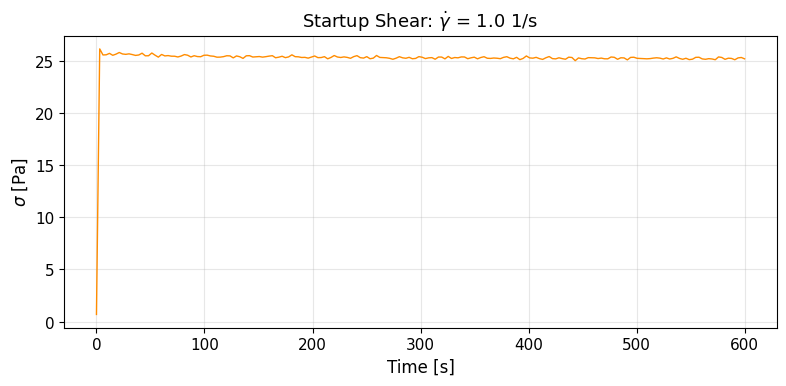

In [3]:
data = load_pnas_startup(gamma_dot=1.0, max_points=200)

print(data.summary())
print(f"\nApplied shear rate: {data.protocol_kwargs['gamma_dot']} 1/s")

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(data.x, data.y, '-', lw=1, color='darkorange')
ax.set_xlabel(data.x_label)
ax.set_ylabel(data.y_label)
ax.set_title(f'Startup Shear: $\\dot{{\\gamma}}$ = {data.protocol_kwargs["gamma_dot"]} 1/s')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [4]:
# Detect overshoot
y = data.y_masked
idx_peak = np.argmax(y)
sigma_peak = y[idx_peak]
t_peak = data.x_masked[idx_peak]

# Estimate steady state from last 20% of data
n_ss = max(10, len(y) // 5)
sigma_ss = np.mean(y[-n_ss:])
overshoot_ratio = sigma_peak / sigma_ss if sigma_ss > 0 else float('nan')

print(f"Peak stress: {sigma_peak:.4g} Pa at t = {t_peak:.4g} s")
print(f"Steady-state stress (est.): {sigma_ss:.4g} Pa")
print(f"Overshoot ratio: {overshoot_ratio:.3f}")
if overshoot_ratio > 1.05:
    print("Stress overshoot detected — V_act is identifiable from this data.")
else:
    print("No clear overshoot — V_act may not be well constrained.")

Peak stress: 26.11 Pa at t = 3.02 s
Steady-state stress (est.): 25.2 Pa
Overshoot ratio: 1.036
No clear overshoot — V_act may not be well constrained.


## 3. Configure HVNM and Fit (NLSQ)

Startup constrains 6 HVNM parameters:
- **G_P, G_E, G_D**: Network moduli (elastic ramp slope = sum of all)
- **nu_0**: BER attempt frequency (E-network relaxation time)
- **k_d_D**: D-network dissociation rate (sets D-network relaxation)
- **V_act**: Stress-activation volume (controls overshoot height and position)

In [5]:
model = HVNMLocal(kinetics="stress", include_dissociative=True)
fit_params = configure_hvnm_for_fit(
    model,
    protocol="startup",
    overrides={
        "G_P": sigma_ss * 0.3,     # Fraction of steady-state from P-network
        "G_E": sigma_ss * 0.3,     # E-network contribution
        "G_D": sigma_ss * 0.5,     # D-network dominates at steady state
        "nu_0": 1e9,
        "k_d_D": 1.0 / t_peak if t_peak > 0 else 1.0,
        "V_act": 1e-4,             # Stress activation volume
        "T": 300.0,
        "phi": 0.0,
    },
)
print(f"Fittable: {fit_params}")

t0 = time.time()
model.fit(
    data.x_masked,
    data.y_masked,
    test_mode="startup",
    gamma_dot=data.protocol_kwargs['gamma_dot'],
    max_iter=3000,
)
print(f"NLSQ: {time.time() - t0:.1f} s")

nlsq_vals = get_nlsq_values(model, fit_params)
for p, v in nlsq_vals.items():
    print(f"  {p} = {v:.4g}")

INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=15 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


Fittable: ['G_P', 'G_E', 'G_D', 'nu_0', 'k_d_D', 'V_act']


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=1.710008s


INFO:nlsq.least_squares:Convergence reason=`xtol` termination condition is satisfied. | iterations=7 | final_cost=274.1155 | elapsed=1.710s | final_gradient_norm=770.2486


NLSQ: 2.3 s
  G_P = 0.1776
  G_E = 0.4416
  G_D = 0.9053
  nu_0 = 3.697e+11
  k_d_D = 8.772e+05
  V_act = 0.0004525


Figure saved: /Users/b80985/Projects/rheojax/examples/hvnm/../../examples/utils/../figures/hvnm/hvnm_04_startup_nlsq_fit.png


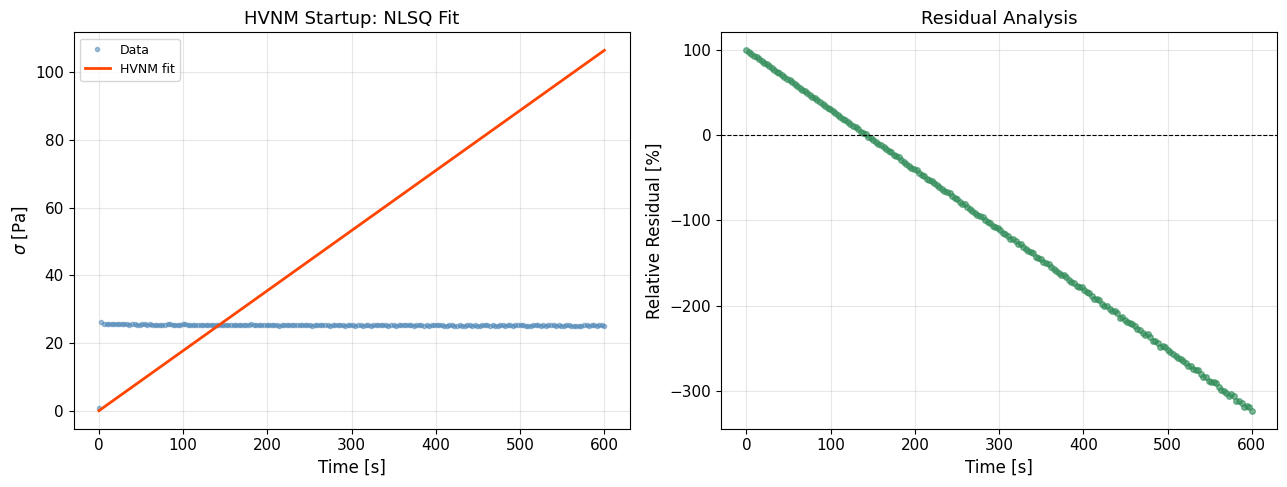

In [6]:
fig = plot_fit_comparison(data, model, title="HVNM Startup: NLSQ Fit")
save_figure(fig, "hvnm_04_startup_nlsq_fit.png")
plt.show()

## 4. Bayesian Inference (NUTS)

Startup ODE integration makes each likelihood evaluation expensive.
NUTS will take longer than algebraic protocols (flow curve, SAOS).

In [7]:
bayes_cfg = get_bayesian_config()
print(f"Config: {bayes_cfg}")

t0 = time.time()
result = model.fit_bayesian(
    data.x_masked,
    data.y_masked,
    test_mode="startup",
    gamma_dot=data.protocol_kwargs['gamma_dot'],
    **bayes_cfg,
)
print(f"NUTS: {time.time() - t0:.1f} s")

Config: {'num_warmup': 50, 'num_samples': 100, 'num_chains': 1}


  0%|          | 0/150 [00:00<?, ?it/s]

warmup:   1%|          | 1/150 [00:01<03:16,  1.32s/it, 1 steps of size 1.95e+00. acc. prob=0.00]

sample:  34%|███▍      | 51/150 [00:01<00:02, 49.40it/s, 255 steps of size 4.67e-04. acc. prob=1.00]

sample:  53%|█████▎    | 80/150 [00:01<00:00, 72.61it/s, 113 steps of size 4.67e-04. acc. prob=0.34]

sample:  81%|████████▏ | 122/150 [00:01<00:00, 120.73it/s, 63 steps of size 4.67e-04. acc. prob=0.18]

sample: 100%|██████████| 150/150 [00:01<00:00, 86.01it/s, 12 steps of size 4.67e-04. acc. prob=0.15] 

NUTS: 4.7 s


## 5. Diagnostics and PPC

In [8]:
print_convergence(result, fit_params)
print()
print_parameter_table(fit_params, nlsq_vals, result.posterior_samples)

Convergence Diagnostics
   Parameter     R-hat       ESS
--------------------------------------------------
         G_P    1.1287         9 *
         G_E    0.9938        22 *
         G_D    1.3177         5 *
        nu_0    1.2507         6 *
       k_d_D    1.0227        19 *
       V_act    1.2183         6 *

Divergences: 62
Convergence: CHECK REQUIRED

Parameter Comparison
       Param          NLSQ    Bayes(med)                    95% CI
------------------------------------------------------------------
         G_P        0.1776      0.005565  [0.005556, 0.01097]
         G_E        0.4416         577.9  [291.5, 1405]
         G_D        0.9053         8.207  [8.138, 14.99]
        nu_0     3.697e+11     5.367e+13  [5.058e+13, 7.809e+13]
       k_d_D     8.772e+05     6.797e+05  [6.749e+05, 6.983e+05]
       V_act     0.0004525       0.00579  [0.005142, 0.005814]


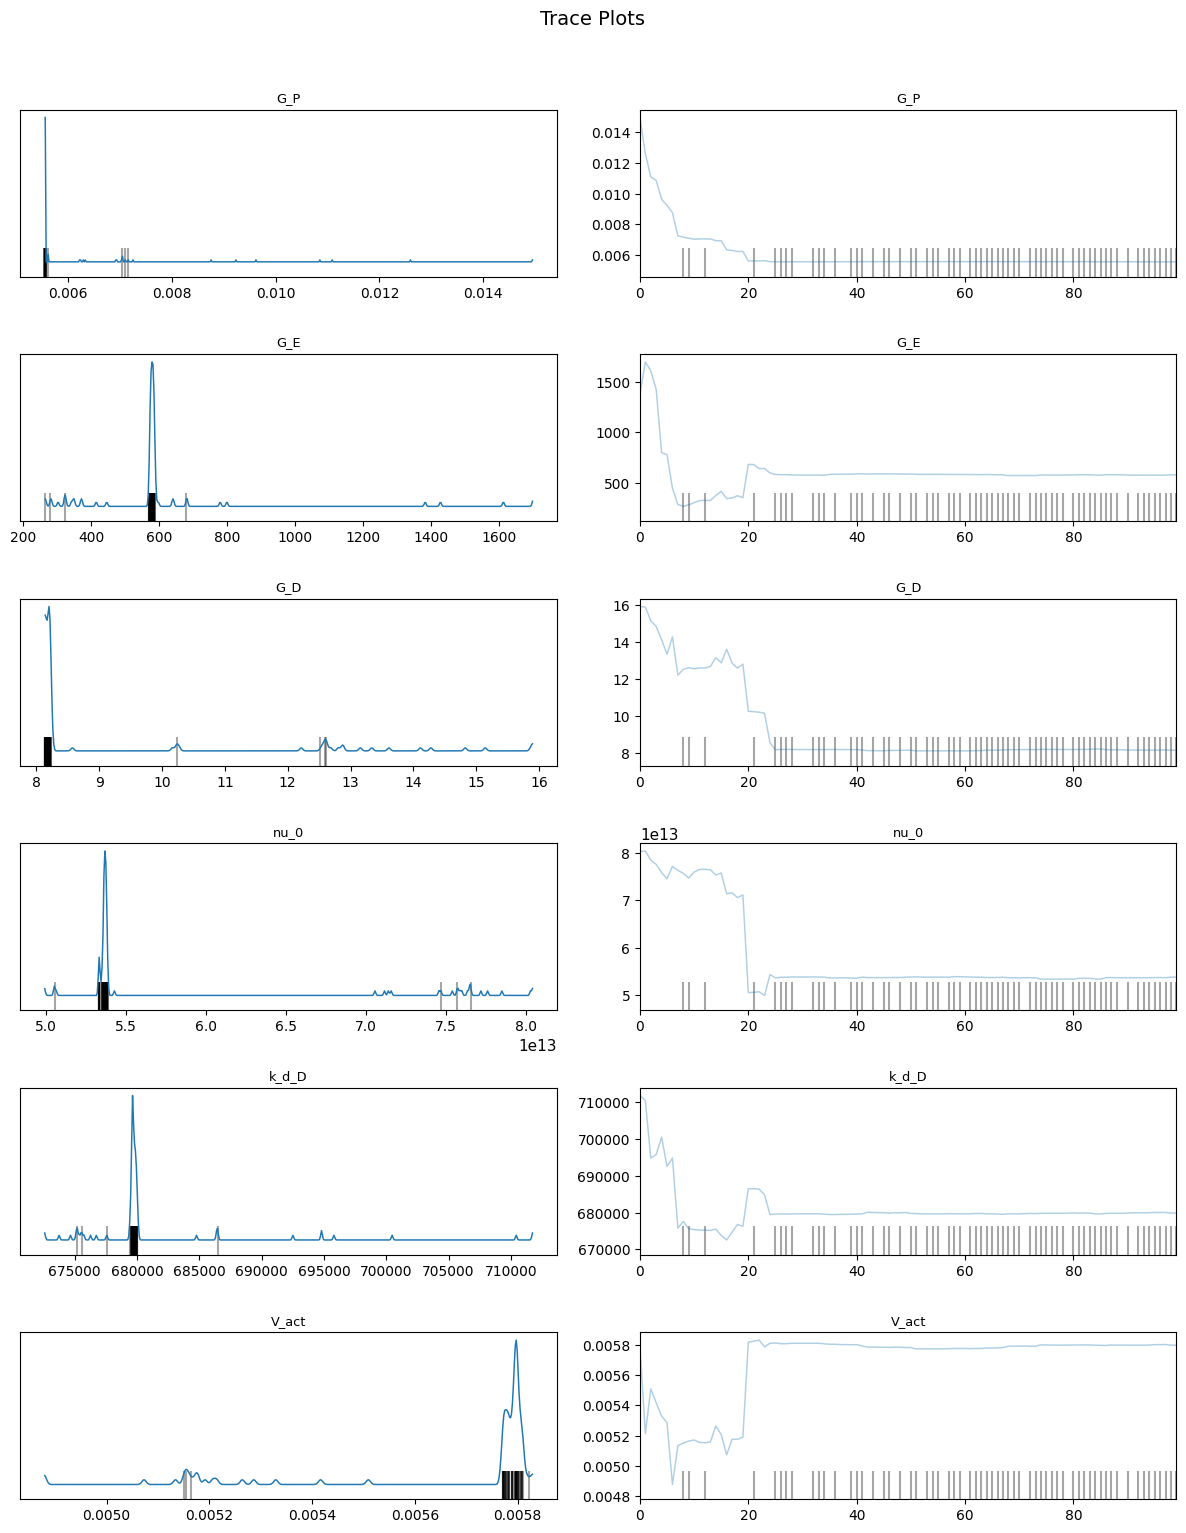

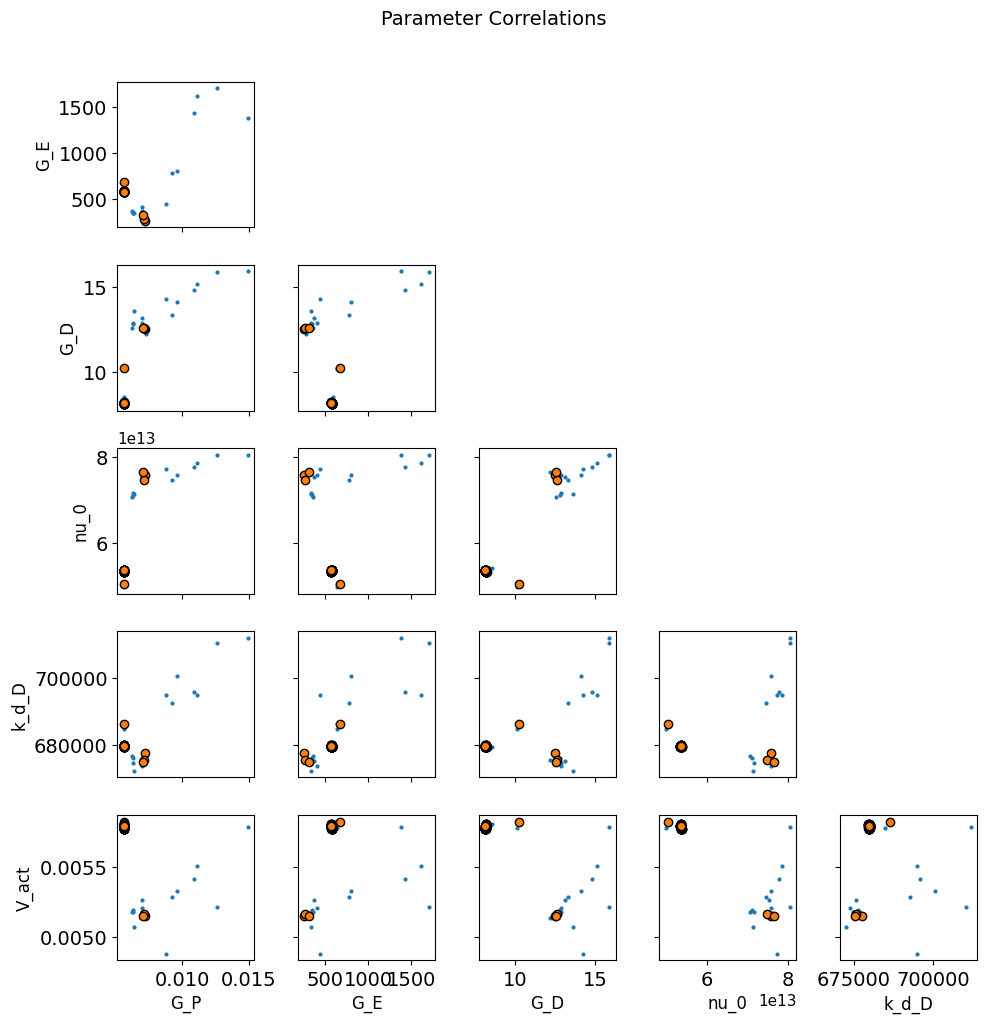

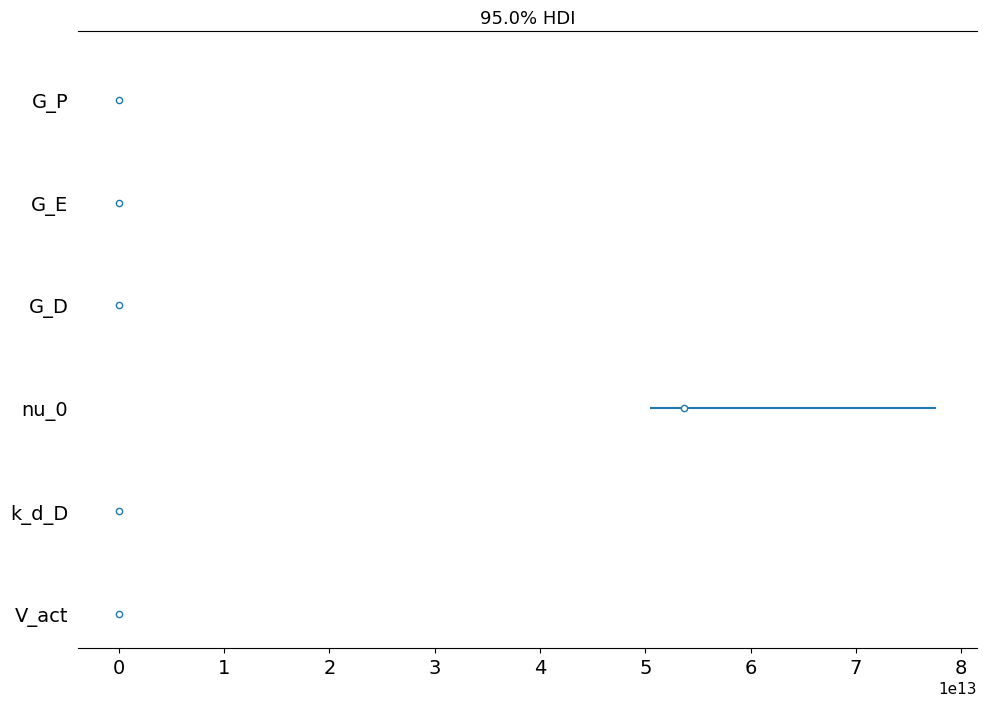

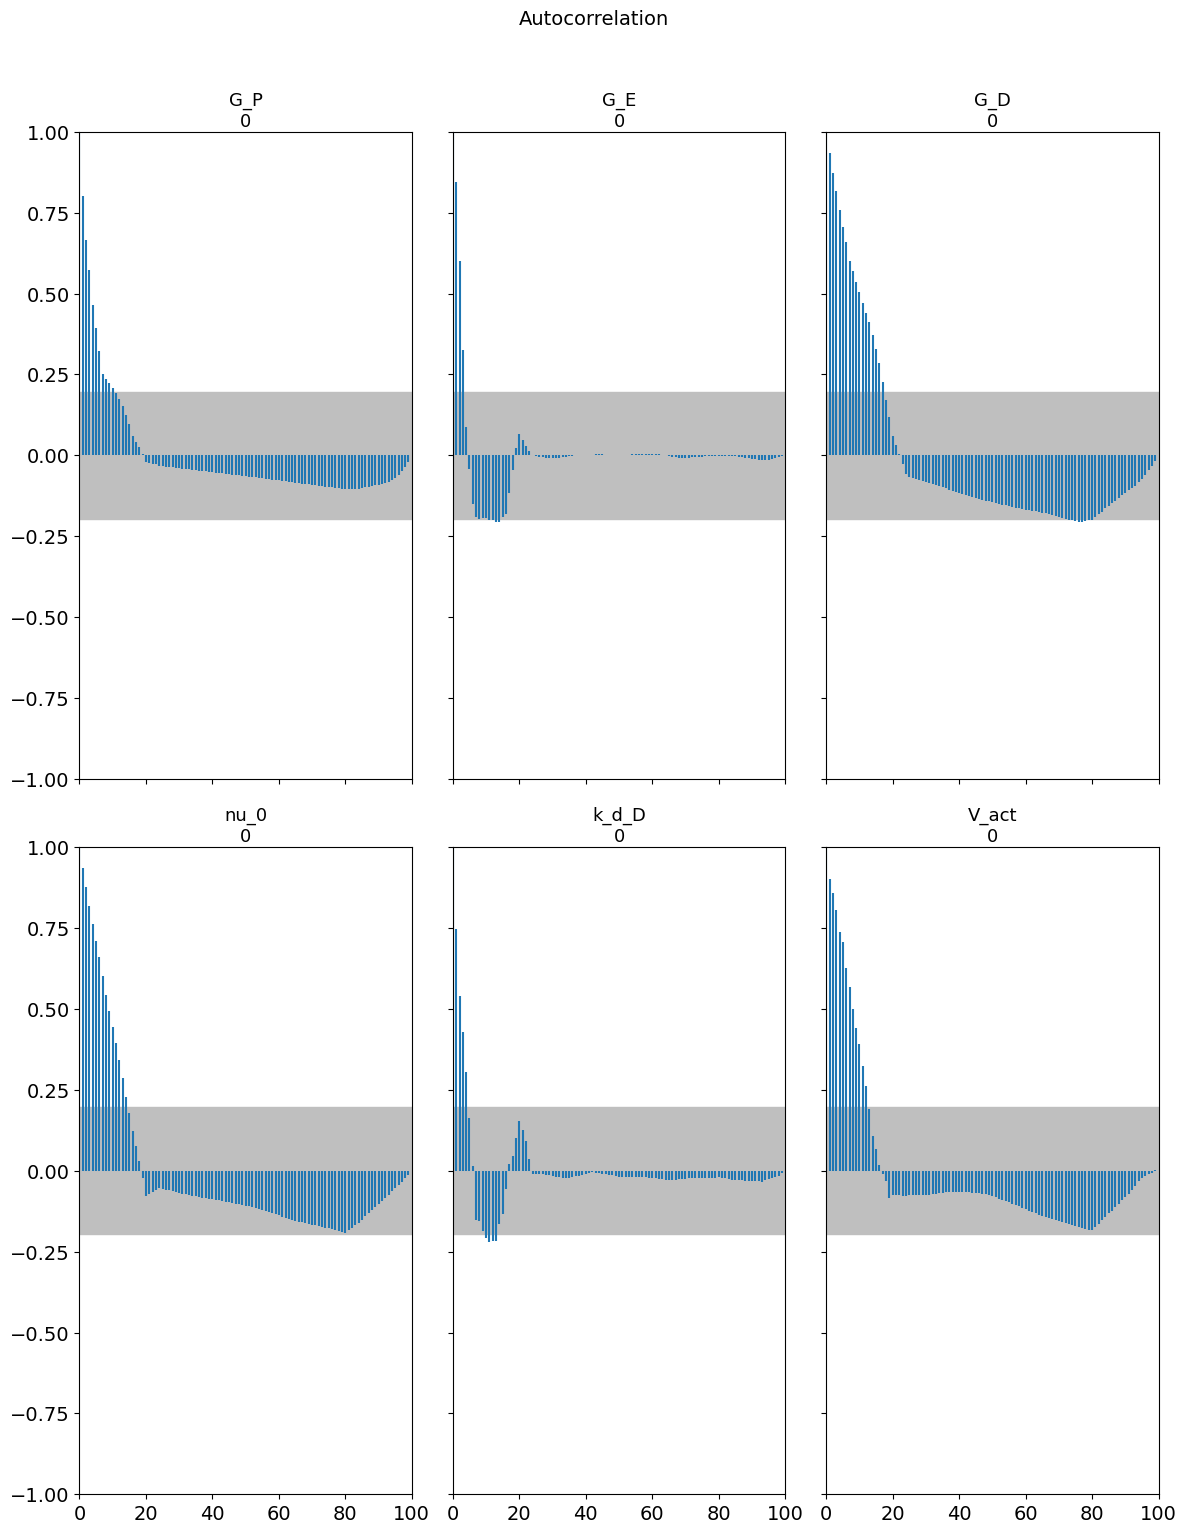

In [9]:
display_arviz_diagnostics(result, fit_params, fast_mode=get_fast_mode())

Figure saved: /Users/b80985/Projects/rheojax/examples/hvnm/../../examples/utils/../figures/hvnm/hvnm_04_startup_ppc.png


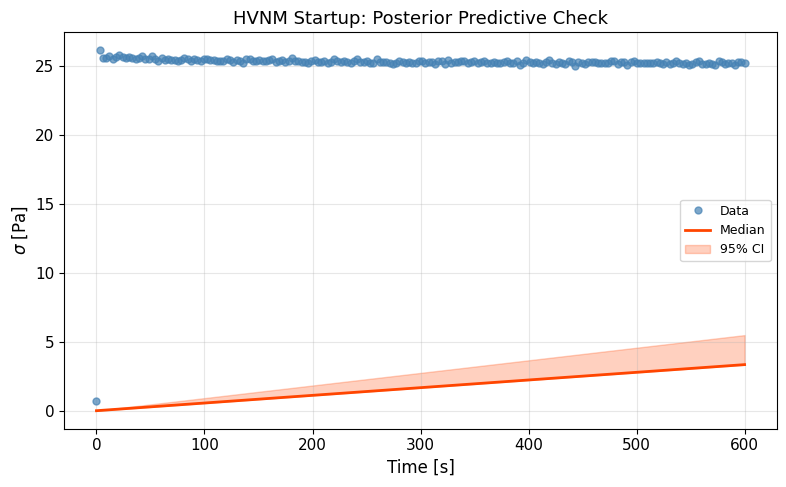

In [10]:
fig = plot_ppc(
    data, model, result.posterior_samples, fit_params,
    title="HVNM Startup: Posterior Predictive Check",
)
save_figure(fig, "hvnm_04_startup_ppc.png")
plt.show()

## 6. Save Results

In [11]:
save_results(
    get_output_dir("startup"), model, result,
    param_names=fit_params,
    extra_meta={
        "dataset": "PNAS_DRT",
        "protocol": "startup",
        "gamma_dot": data.protocol_kwargs['gamma_dot'],
    },
)

Saved to /Users/b80985/Projects/rheojax/examples/hvnm/../../examples/utils/../outputs/hvnm/startup/


## What to Change for Your Data

1. **Shear rate**: Change `gamma_dot` in `load_pnas_startup()` or supply your own data
2. **V_act kinetics**: Set `kinetics="stretch"` for stretch-based TST if stress-based doesn't fit
3. **Multiple shear rates**: Run this notebook at several $\dot{\gamma}$ and compare V_act consistency
4. **Nanoparticles**: Set `phi > 0` for nanocomposites
5. **Temperature**: Update `T` override

## Troubleshooting

- **No overshoot in fit**: Increase `V_act` initial guess. V_act = 0 gives monotone approach to steady state
- **ODE solver divergence**: Reduce `gamma_dot` or increase `max_iter` in NLSQ
- **Slow NUTS**: Startup requires ODE at each evaluation. Use FAST_MODE for exploration, production for publication
- **V_act unconstrained**: If there's no overshoot in the data, V_act can't be identified. Fix it and fit the other 5 params
- **Elastic ramp too steep/shallow**: G_P + G_E + G_D controls the initial slope. Adjust initial guesses accordingly